In [11]:
import os
import pickle

import random
import pandas as pd
import numpy as np

from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from statsmodels.tsa.ar_model import AR
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import graphics
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.model_selection import TimeSeriesSplit, KFold, GridSearchCV, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

import inspect
import warnings

from pygam import LinearGAM

In [12]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

def int_plot_3d(estimator, Vars_discretized, X, Y, free_vars, angle):
    free_vals = []
    for fv in range(len(free_vars)):
        free_vals.append(random.choice(Vars_discretized[free_vars[fv]]))

    pred_vals = []
    for i in Vars_discretized[Y]:
        cur_line = []
        for j in Vars_discretized[X]:
            cur_feat = len(param)*[0]
            cur_feat[param.index(X)] = j
            cur_feat[param.index(Y)] = i
            for fv in range(len(free_vars)):
                cur_feat[param.index(free_vars[fv])] = free_vals[fv]     
            cur_feat = np.array(cur_feat).reshape(1, -1)
            cur_line.append(estimator.predict(cur_feat)[0])
        pred_vals.append(np.array(cur_line))
    pred_vals = np.array(pred_vals)

    plt_X, plt_Y = np.meshgrid(Vars_discretized[X], Vars_discretized[Y])
   
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca(projection = '3d')
    ax.view_init(azim = angle)
    surf = ax.plot_surface(plt_X, plt_Y, pred_vals, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    plt.xlabel(X)
    plt.ylabel(Y)
    plt.tight_layout()
    plt.show()

def gen_basis_functions(arg, order_low, order_high):
    output = {}
    for i in range(order_low, order_high + 1):
        output['x^' + str(i)] = np.power(arg, i)
    return output

def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

MAE_scorer = make_scorer(MAE, greater_is_better = False)

def MAPE(y, y_pred):
    return np.sum(np.abs(y - y_pred)) / np.sum(y)

MAPE_scorer = make_scorer(MAPE, greater_is_better = False)

def CAPE(y, y_pred):
    return np.abs(np.sum(y - y_pred)) / np.sum(y)

CAPE_scorer = make_scorer(CAPE, greater_is_better = False)

def fit_grid_and_print(grid, X, y):
    grid.fit(X, y)

    print("Grid scores on development set:")
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
            % (mean, 2 * std, params))
    print()
    print("Best score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
    print(grid.best_params_)
    
def plot_predicts(estimator, X, y, x_axis, lb_lags = 12):

    y_true = y
    y_pred = estimator.predict(X)

    fig, ax = plt.subplots(figsize = (12, 4))
    ax.plot(x_axis, y_pred, label='Predicted')
    ax.plot(x_axis, y_true, label='Actual')
    plt.title('Actual vs predicted')
    plt.legend()
    plt.show()

    lb = acorr_ljungbox(y_true-y_pred, lags = lb_lags)
    print('Ljung-Box test:')
    print(pd.DataFrame({'stat': lb[0], 'p-value': lb[1]}, index = range(1, lb_lags+1)))

def print_KFold_scores(estimator, X, y, win_len = 3):
    MAE_scores = -cross_val_score(estimator = estimator, X = X, y = y, 
                                  cv = KFold(n_splits = len(y) // win_len), scoring = MAE_scorer)
    MAPE_scores = -cross_val_score(estimator = estimator, X = X, y = y,
                                   cv = KFold(n_splits = len(y) // win_len), scoring = MAPE_scorer)
    CAPE_scores = -cross_val_score(estimator = estimator, X = X, y = y,
                                   cv = KFold(n_splits = len(y) // win_len), scoring = CAPE_scorer)
    
    print(KFold(n_splits = len(y) // win_len))
    print ()       
    print ('Average MAE on the cross-validation set is %0.3f.' % np.mean(MAE_scores))
    print ('Average MAPE on the cross-validation set is %0.3f%%.' % (100 * np.mean(MAPE_scores)))
    print ('Average CAPE on the cross-validation set is %0.3f%%.' % (100 * np.mean(CAPE_scores)))
    print ()
    print ('Last 3 months MAE is %0.3f.' % MAE_scores[-1])
    print ('Last 3 months MAPE is %0.3f%%.' % (100 * MAPE_scores[-1]))
    print ('Last 3 months CAPE is %0.3f%%.' % (100 * CAPE_scores[-1])) 

class LinearGAM_sklearn(BaseEstimator, RegressorMixin):
    def __init__(self, callbacks = ['deviance', 'diffs'], constraints = None, dtype = 'auto', lam = 0.6, 
                 fit_intercept = False, fit_linear = False, fit_splines = True, max_iter = 100,
                 penalties = 'auto', n_splines = 25, scale = None, spline_order = 3, tol = 1e-4):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        
        for arg, val in values.items():
            setattr(self, arg, val)
    
        self.model = LinearGAM(callbacks = self.callbacks, constraints = self.constraints, dtype = self.dtype,
                     lam = self.lam, fit_intercept = self.fit_intercept, fit_linear = self.fit_linear,
                     fit_splines = self.fit_splines, max_iter = self.max_iter, penalties = self.penalties,
                     n_splines = self.n_splines, scale = self.scale, spline_order = self.spline_order, tol = self.tol)
    
    def set_params(self, **params):
        for arg, val in params.items():
            setattr(self, arg, val)
            new_param = {arg: val}
            self.model.set_params(**new_param)
        
        return self     
    
    def fit(self, X, y = None):
        self.model.fit(X, y);
                
        return self       
    
    def predict(self, X, y = None):
        
        return self.model.predict(X)
    
    def summary(self):
        
        return self.model.summary()

def generate_features(data, y, Selected_features):
    data_res = pd.DataFrame()
    data_res['date'] = data['date']
    data_res[y] = data[y]

    max_order = 0
    for feat in Selected_features:
        if feat in data.columns:
            data_res[feat] = data[feat]
        else:
            if (feat[-3:-1] == '_L'):
                feat_type = 'lag'
            elif (feat[-3:-1] == '_d'):
                feat_type = 'delta'
            else:
                feat_type = False
            feat_order = int(feat[-1])

            if (feat_type and (feat_order > 0)):
                max_order = max(max_order, feat_order)

                if (feat_type == 'lag'):
                    data_res[feat] = data[feat[:-3]].shift(feat_order)
                elif (feat_type == 'delta'):
                    data_res[feat] = data[feat[:-3]].shift(feat_order-1) - data[feat[:-3]].shift(feat_order)

    data_res = data_res.iloc[max_order:]
    return data_res

# Exploratory data analysis

In [13]:
file_name = os.getcwd().split('\\')[-1]

xls = pd.ExcelFile(file_name + ".xlsx")
data = xls.parse(xls.sheet_names[0]).sort_values('date')

param_data = list(data.columns)
param_data.remove('date')
param_data.remove('target')

y = 'target'

data['time_index'] = data.index.astype(float)
data["month"] = data["date"].apply(lambda d: d.month)
data["year"] = data["date"].apply(lambda d: d.year)

data = data.dropna()

CV_splits = len(data.index) // 3

test_len = 0
split_index = len(data.index) - test_len

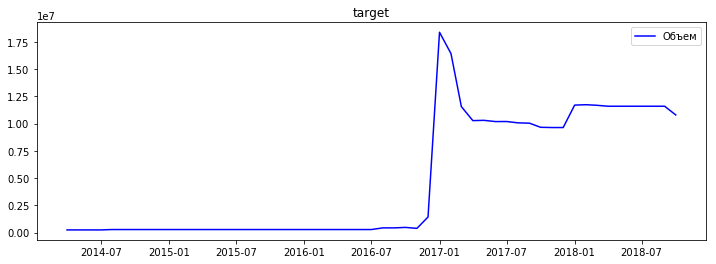

In [14]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(data['date'], data[y], label='Объем', color = 'blue')
plt.title(y)
plt.legend()
plt.show()

# Regression analysis

In [15]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

## Step 1. Kernel regression for trend

Grid MAE scores on development set:
-5052146.654 (+/-3607524.180) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 0.01}
-4181524.558 (+/-3984867.954) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 0.05}
-3661380.139 (+/-4373667.841) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 0.1}
-2870029.436 (+/-4714635.462) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 0.5}
-2707846.421 (+/-5104926.369) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 1.0}
-2807385.622 (+/-5834128.905) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 2.5}
-3051418.402 (+/-6512160.524) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 5.0}
-3380046.489 (+/-7346699.692) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 10}
-3594791.143 (+/-7875925.005) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 15}
-3868701.165 (+/-8522064.525) for {'kernelridge__alpha': 10.0, 'kernelridge__gamma': 25}

Best MAE score is -2707846.421. Best parameters set found on dev

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


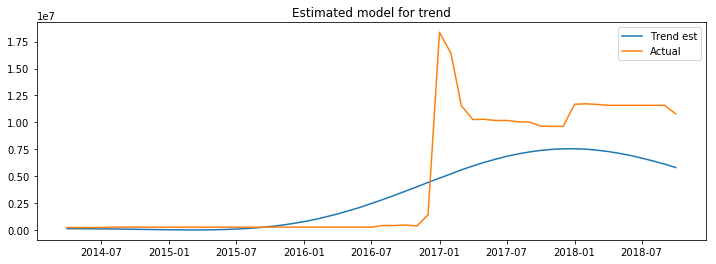

In [17]:
estm_s1 = make_pipeline(StandardScaler(), KernelRidge(kernel = 'rbf'))
tuned_parameters = [{'kernelridge__gamma': [0.01, 0.05, 0.1, 0.5, 1.0, 2.5, 5.0, 10, 15, 25],
                     'kernelridge__alpha': [10.0]}]

grid = GridSearchCV(estimator=estm_s1, param_grid=tuned_parameters,
                   cv=CV_splits, scoring="neg_mean_absolute_error")
grid.fit(data_train['time_index'].values.reshape(-1, 1), data_train[y].values)

print("Grid MAE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MAE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

estm_s1.set_params(**grid.best_params_)
estm_s1.fit(data_train['time_index'].values.reshape(-1, 1), data_train[y].values)

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(data['date'], estm_s1.predict(data['time_index'].values.reshape(-1, 1)), label='Trend est')
ax.plot(data['date'], data[y], label='Actual')
plt.title('Estimated model for trend')
plt.legend()
plt.show()

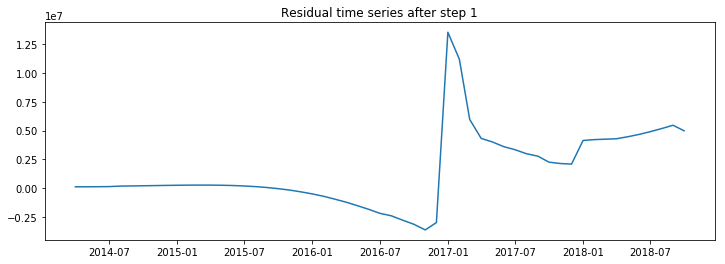

In [18]:
data['trend_est'] = estm_s1.predict(data['time_index'].values.reshape(-1, 1))
data['y_res1'] = data[y] - data['trend_est']

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(data['date'], data['y_res1'])
plt.title('Residual time series after step 1')
plt.show()

## Step 2. Gradient boosting regression for seasonality

Grid scores on development set:
-2478700.041 (+/-3279783.651) for {'n_estimators': 1}
-2262787.452 (+/-3204450.080) for {'n_estimators': 2}
-1770066.403 (+/-2977879.518) for {'n_estimators': 5}
-1275720.995 (+/-2763416.571) for {'n_estimators': 10}
-943548.434 (+/-2643757.500) for {'n_estimators': 20}
-933191.863 (+/-2577683.939) for {'n_estimators': 30}
-902575.644 (+/-2508285.678) for {'n_estimators': 50}
-871033.058 (+/-2538292.801) for {'n_estimators': 100}
-885054.723 (+/-2559706.514) for {'n_estimators': 200}
-890273.182 (+/-2546072.133) for {'n_estimators': 300}
-882244.964 (+/-2546391.952) for {'n_estimators': 500}

Best score is -871033.058. Best parameters set found on development set:
{'n_estimators': 100}


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


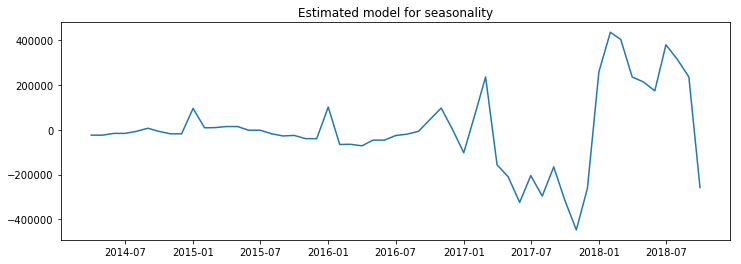

In [19]:
param = ['trend_est', 'month']

data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

estm_s2 = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 2)
estm_s2t = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 2)

tuned_parameters = [{'n_estimators': [1, 2, 5, 10, 20, 30, 50, 100, 200, 300, 500]}]

grid = GridSearchCV(estimator=estm_s2, param_grid=tuned_parameters,
                   cv=CV_splits, scoring="neg_mean_absolute_error")
fit_grid_and_print(grid, X = data_train[param], y = data_train['y_res1'])

estm_s2.set_params(**grid.best_params_)
estm_s2.fit(X = data_train[param], y = data_train['y_res1'])

estm_s2t.set_params(**grid.best_params_)
estm_s2t.fit(X = data_train[['trend_est']], y = data_train['y_res1'])

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(data['date'], estm_s2.predict(data[param]) - estm_s2t.predict(data[['trend_est']]))
plt.title('Estimated model for seasonality')
plt.show()

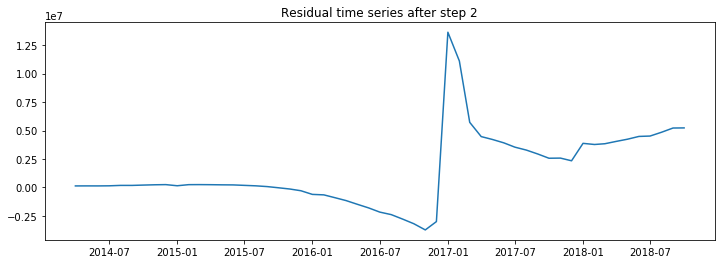

In [20]:
data['seas_est'] = estm_s2.predict(data[param]) - estm_s2t.predict(data[['trend_est']])
data['y_res2'] = data['y_res1'] - data['seas_est']

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(data['date'], data['y_res2'])
plt.title('Residual time series after step 2')
plt.show()

### Elements of seasonal effects and their interaction with trend

In [21]:
for i in range(len(param)):
    print ('Importance of', param[i] + " - " + str(np.round(estm_s2.feature_importances_[i], 2)))    

Importance of trend_est - 0.99
Importance of month - 0.01


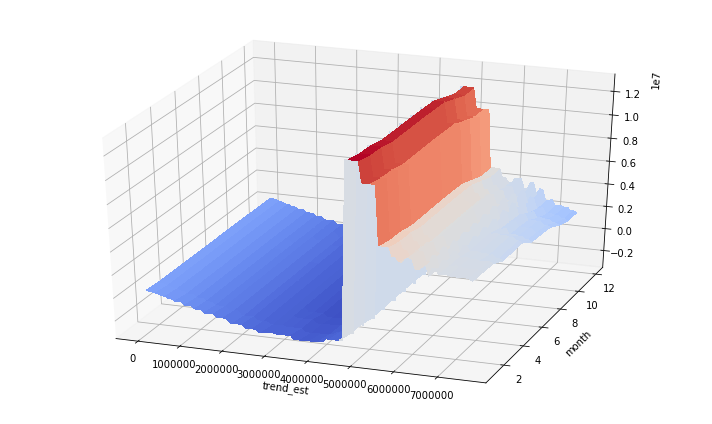

In [22]:
discretization_steps = 100
Vars_discretized = {}
Vars_discretized['trend_est'] = np.arange(data['trend_est'].min(), data['trend_est'].max() + 1, 
                    (1/discretization_steps) * (data['trend_est'].max() - data['trend_est'].min()))
Vars_discretized['month'] = np.arange(data['month'].min(), data['month'].max() + 1, 1)

X = 'trend_est'
Y = 'month'
free_vars = []

angle = 290
int_plot_3d(estm_s2, Vars_discretized, X, Y, free_vars, angle)

## Step 3. Unit root test

In [23]:
adf = adfuller(data['y_res2'], regression = 'nc')

adf_stat = round(adf[0], 4)
adf_p_val = round(adf[1], 4)

print ('stat: ', adf_stat, ', p-val: ', adf_p_val)

stat:  -2.4093 , p-val:  0.0154


## Step 4. Autocorrelation function plots

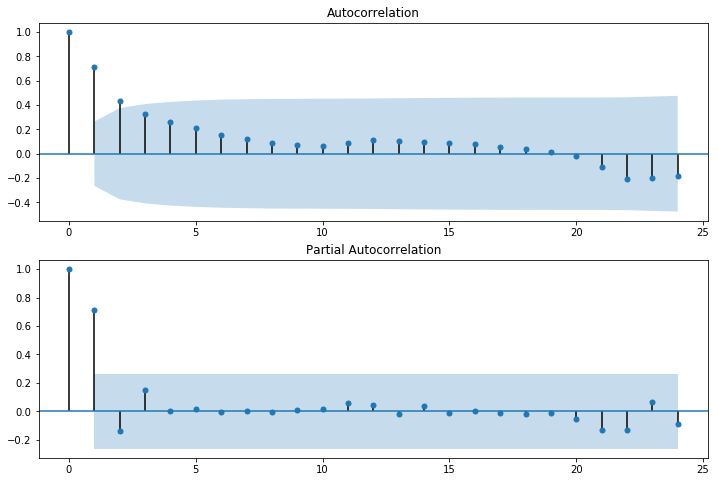

In [24]:
fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(211)
fig = graphics.tsa.plot_acf(data['y_res2'], lags = 24, ax = ax1)

ax2 = fig.add_subplot(212)
fig = graphics.tsa.plot_pacf(data['y_res2'], lags = 24, ax = ax2)

plt.show()

## Step 5. Checking collinearity of features

In [25]:
data_1 = data.copy()

data_1['Const'] = 1.0
data_1['month'] = data['month']

param = param_data.copy()

### Dropping constants

In [26]:
for p in param:
    if np.std(data_1[p]) == 0:
        print ('column ' + p + ' has no variance')
        del data_1[p]

### Generating lags and deltas

In [27]:
L_param = []
for feat in param:
    data_1[feat + '_d1'] = data_1[feat] - data_1[feat].shift(1)
    L_param.append(feat + '_d1')

for L in range(1,2):
    data_1[y + '_L' + str(L)] = data_1[y].shift(L)
    L_param.append(y + '_L' + str(L))
    
for L in range(2,3):
    data_1[y + '_d' + str(L)] = data_1[y].shift(L-1) - data_1[y].shift(L)
    L_param.append(y + '_d' + str(L))
    
param.extend(L_param)   
data_1 = data_1.dropna()

### Checking collinearity

In [28]:
to_remove = []
for i in range(len(param)):
    for j in range(i):
        cr = abs(data_1[param].corr().iloc[i,j])
        if (cr > 0.8) and (param[i] not in to_remove) and (param[j] not in to_remove):           
            print ('Correlation between ', param[i], ' and ', param[j], ' is %0.3f' % cr)
            to_remove.append(param[j])

Correlation between  USD  and  Нефть марки urals  is 0.859
Correlation between  NDS_TERITORY_INTERPOLATED  and  Unemployment rate  is 0.836
Correlation between  USD_d1  and  Нефть марки urals_d1  is 0.833
Correlation between  PROPERTY_TERRITORY_INTERPOLATED_d1  and  realGDP_d1  is 0.866
Correlation between  TRANSPORT_TERRITORY_INTERPOLATED_d1  and  PROPERTY_TERRITORY_INTERPOLATED_d1  is 0.845


In [29]:
for rem in to_remove:
    param.remove(rem)
    del data_1[rem]
    
param.extend(['Const', 'month'])

## Step 6. Feature selection with RFECV on Ridge

In [30]:
data_train = data_1.iloc[:split_index]
data_test = data_1.iloc[split_index:]

#estm_s3 = RandomForestRegressor(n_estimators=250, criterion='mae', max_depth=3, max_features='auto')

estm_s3 = Ridge(alpha = 1e+12)
selector = RFECV(estm_s3, cv=KFold(n_splits = CV_splits), scoring=MAE_scorer, step=1)
selector = selector.fit(data_train[param], data_train[y])

Select_Res = pd.DataFrame(selector.ranking_, index = param).rename(
             columns = {0: 'Rank'}).sort_values(by = 'Rank', axis = 0).iloc[:20]

Select_Res

,Rank
AREA_TERITORY_INTERPOLATED,1
target_L1,1
NDFL_TERRITORY_INTERPOLATED,2
NDFL_TERRITORY_INTERPOLATED_d1,3
AREA_TERITORY_INTERPOLATED_d1,4
NDS_TERITORY_INTERPOLATED,5
NDS_TERITORY_INTERPOLATED_d1,6
TRANSPORT_TERRITORY_INTERPOLATED_d1,7
target_d2,8
TRANSPORT_TERRITORY_INTERPOLATED,9


### Feature selection

In [31]:
Selected_features = list(Select_Res.index)[:3]

Selected_features

['AREA_TERITORY_INTERPOLATED', 'target_L1', 'NDFL_TERRITORY_INTERPOLATED']

### Checking multicollinearity

In [32]:
# Is condition number less than 15?

cov_m = data_1[Selected_features].corr().values
eig_values, eig_vectors = np.linalg.eig(cov_m)
print ("Condition number is ", np.sqrt(np.max(eig_values) / np.min(eig_values)))

Condition number is  1.1844506747350119



## Step 7. Model choice

In [33]:
data_2 = data_1.copy()

CV_splits = len(data_2.index) // 3

test_len = 0
split_index = len(data_2.index) - test_len

data_train = data_2.iloc[:split_index]
data_test = data_2.iloc[split_index:]

### Linear regression

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    OLS_reg = OLS(endog = data_train[y], exog = data_train[Selected_features]).fit()
    print (OLS_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     153.5
Date:                Tue, 04 Dec 2018   Prob (F-statistic):           3.26e-25
Time:                        17:26:03   Log-Likelihood:                -852.60
No. Observations:                  53   AIC:                             1711.
Df Residuals:                      50   BIC:                             1717.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
AREA_TERITORY_INTE

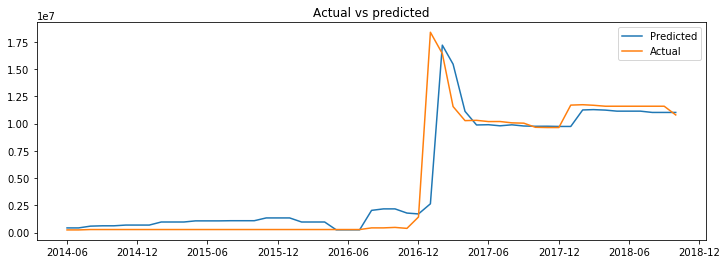

Ljung-Box test:
     p-value      stat
1   0.787335  0.072777
2   0.212039  3.101969
3   0.310474  3.580473
4   0.464416  3.589401
5   0.609757  3.590390
6   0.660226  4.121587
7   0.716155  4.537848
8   0.778647  4.800731
9   0.850341  4.812456
10  0.897939  4.897194
11  0.935642  4.905815
12  0.941641  5.440161


In [35]:
estm = LinearRegression(fit_intercept = False)
estm.fit(data_train[Selected_features], data_train[y])

plot_predicts(estimator = estm, X = data_train[Selected_features], y = data_train[y], 
              x_axis = data_train['date'])

In [36]:
estm = LinearRegression(fit_intercept = False)
print_KFold_scores(estimator = estm, X = data_train[Selected_features], y = data_train[y])

KFold(n_splits=17, random_state=None, shuffle=False)

Average MAE on the cross-validation set is 1176826.454.
Average MAPE on the cross-validation set is 164.759%.
Average CAPE on the cross-validation set is 164.458%.

Last 3 months MAE is 472430.460.
Last 3 months MAPE is 4.174%.
Last 3 months CAPE is 3.126%.


### Linear GAM

In [37]:
dtype = 'numerical'
penalties = 'derivative'
fit_splines = True
fit_linear = False

estm = LinearGAM_sklearn(fit_intercept = False, fit_linear = fit_linear, fit_splines = fit_splines,
                         penalties = penalties, dtype = dtype)

tuned_parameters = [{'lam': [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99],
                     'n_splines': [3,4,5],
                     'spline_order': [2]
                   }]

grid = GridSearchCV(estimator=estm, param_grid=tuned_parameters, cv=KFold(n_splits=CV_splits), scoring=MAE_scorer)
fit_grid_and_print(grid = grid, X = data_train[Selected_features], y = data_train[y])

Grid scores on development set:
-757421.764 (+/-2563847.046) for {'lam': 0.01, 'n_splines': 3, 'spline_order': 2}
-1128664.321 (+/-2726615.001) for {'lam': 0.01, 'n_splines': 4, 'spline_order': 2}
-1677151.892 (+/-3788168.779) for {'lam': 0.01, 'n_splines': 5, 'spline_order': 2}
-921441.364 (+/-2617615.037) for {'lam': 0.1, 'n_splines': 3, 'spline_order': 2}
-717016.623 (+/-2671945.739) for {'lam': 0.1, 'n_splines': 4, 'spline_order': 2}
-760208.549 (+/-2675168.566) for {'lam': 0.1, 'n_splines': 5, 'spline_order': 2}
-1045834.786 (+/-2666514.488) for {'lam': 0.25, 'n_splines': 3, 'spline_order': 2}
-799042.692 (+/-2672678.423) for {'lam': 0.25, 'n_splines': 4, 'spline_order': 2}
-680645.022 (+/-2679799.497) for {'lam': 0.25, 'n_splines': 5, 'spline_order': 2}
-1112889.821 (+/-2702244.506) for {'lam': 0.5, 'n_splines': 3, 'spline_order': 2}
-882347.994 (+/-2669803.957) for {'lam': 0.5, 'n_splines': 4, 'spline_order': 2}
-717296.137 (+/-2677487.607) for {'lam': 0.5, 'n_splines': 5, 'spli

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


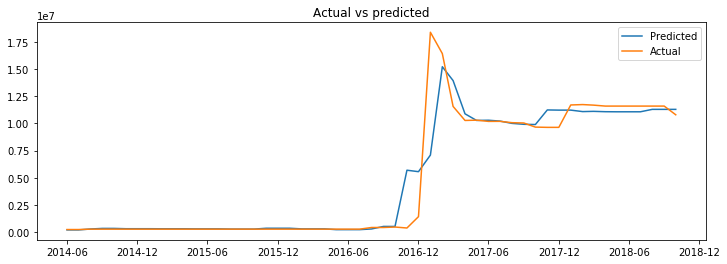

Ljung-Box test:
     p-value       stat
1   0.746198   0.104753
2   0.001047  13.722899
3   0.003238  13.768579
4   0.007206  14.028068
5   0.015391  14.034652
6   0.029242  14.035540
7   0.050475  14.039983
8   0.079687  14.080652
9   0.118750  14.101796
10  0.134632  14.930077
11  0.176629  15.129859
12  0.195970  15.897631


In [38]:
estm.set_params(**grid.best_params_)
estm.fit(X = data_train[Selected_features], y = data_train[y])

plot_predicts(estimator = estm, X = data_train[Selected_features], y = data_train[y], 
              x_axis = data_train['date'])

In [39]:
estm.set_params(**grid.best_params_)
print_KFold_scores(estimator = estm, X = data_train[Selected_features], y = data_train[y])

KFold(n_splits=17, random_state=None, shuffle=False)

Average MAE on the cross-validation set is 705141.908.
Average MAPE on the cross-validation set is 24.103%.
Average CAPE on the cross-validation set is 21.859%.

Last 3 months MAE is 374413.068.
Last 3 months MAPE is 3.308%.
Last 3 months CAPE is 0.528%.


In [40]:
estm.set_params(**grid.best_params_)
estm.fit(X = data_train[Selected_features], y = data_train[y])

with open('model.pkl', "wb") as f:
    pickle.dump(estm.model, f)

with open('Selected_features.pkl', "wb") as f:
    pickle.dump(Selected_features, f)

# Prediction

In [41]:
with open('model.pkl', "rb") as f:
    estm = pickle.load(f)

with open('Selected_features.pkl', "rb") as f:
    Selected_features = pickle.load(f)

In [42]:
file_name = os.getcwd().split('\\')[-1]

xls = pd.ExcelFile(file_name + ".xlsx")
data_p = xls.parse(xls.sheet_names[0]).sort_values('date')

y = 'target'

data_p['target_true'] = data_p[y]
data_p['time_index'] = data_p.index.astype(float)
data_p["month"] = data_p["date"].apply(lambda d: d.month)
data_p["year"] = data_p["date"].apply(lambda d: d.year)

# Set hold-out size here
test_len = 0
split_index = len(data_p[y].dropna().index) - test_len

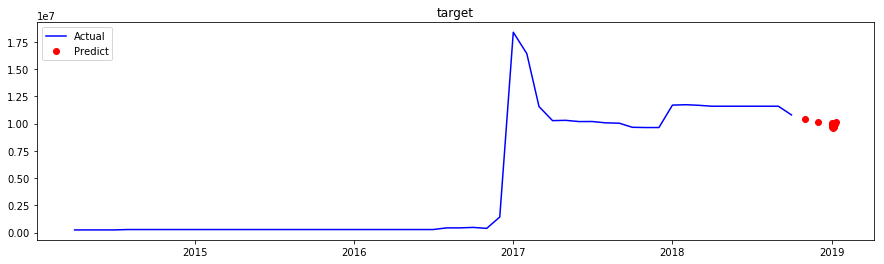

In [162]:
# Remove obs in hold-out set
data_p.loc[data_p[y].dropna().iloc[split_index:].index, y] = np.nan
data_iter = data_p[data_p[y].isnull()].copy()

# Refit model
data_X = generate_features(data_p.iloc[:split_index], y, Selected_features)
estm.fit(X = data_X[Selected_features], y = data_X[y])

# Iterate through missing targets
for ind, row in data_iter.iterrows():
    data_X = generate_features(data_p, y, Selected_features)
    pred = estm.predict(data_X[Selected_features].loc[ind].values.reshape(1,-1))
    data_p.loc[ind, y] = pred[0]

data_p.loc[data_p[y].dropna().iloc[:split_index].index, y] = np.nan

# Plot results
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(data_p['date'], data_p['target_true'], label='Actual', color = 'blue')
ax.plot(data_p['date'], data_p[y], label='Predict', color = 'red', marker = "o", linestyle = 'none')
plt.title(y)
plt.legend(loc = 'upper left')
plt.show()

In [163]:
data_p[['target_true', y]]

,target_true,target
0,2.455932e+05,NaN
1,2.455932e+05,NaN
2,2.455932e+05,NaN
3,2.455932e+05,NaN
4,2.806780e+05,NaN
5,2.806780e+05,NaN
6,2.806780e+05,NaN
7,2.806780e+05,NaN
8,2.806780e+05,NaN
9,2.806780e+05,NaN


In [10]:
data_p['date']

NameError: name 'data_p' is not defined